### From https://www.kaggle.com/c/optiver-realized-volatility-prediction/overview

# Import Package

In [63]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sys.path.append('../../stock_volatility')
from sklearn.model_selection import train_test_split
from utils.metrics_calculation import (
    cal_series_log_return,
    cal_realized_volatility,
    evaluation
)
from utils.baseline import (
    create_baseline_pred
)

# Import Data

In [2]:
book_df = pd.read_parquet('../data/book_train.parquet')
trade_df = pd.read_parquet('../data/trade_train.parquet')
response_df = pd.read_csv('../data/train.csv')

# EDA

### Data Example

In [3]:
book_df.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [4]:
trade_df.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [5]:
response_df.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


### Let's look what is in a bucket

Number of unique "bucket"

In [6]:
book_df["time_id"].nunique()

3830

Number of time_id per bucket

In [7]:
book_df.groupby(by="time_id").agg({"seconds_in_bucket": pd.Series.nunique})

,seconds_in_bucket
time_id,
5,600
11,600
16,600
31,600
62,600
...,...
32751,600
32753,600
32758,600


Exactly 10 mins each

### Let's look at the stock

In [8]:
trade_df["stock_id"].nunique()

112

### Create wap log return for stocks

In [9]:
book_df = cal_series_log_return(book_df)

In [10]:
book_df.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap,log_return
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0,1.001434,NaN
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,1.001448,0.000014
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,1.001448,0.000000
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,1.001443,-0.000005
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,1.001443,0.000000


#### Use stock_id = 0 and time_id = 5

In [11]:
ex_data = book_df.loc[(book_df["stock_id"] == 0) & (book_df["time_id"] == 5)]

In [12]:
ex_data

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap,log_return
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0,1.001434,NaN
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0,1.001448,0.000014
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0,1.001448,0.000000
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,1.001443,-0.000005
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,1.001443,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0,1.003731,0.000245
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0,1.003731,0.000000
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0,1.003731,0.000000
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0,1.003731,0.000000


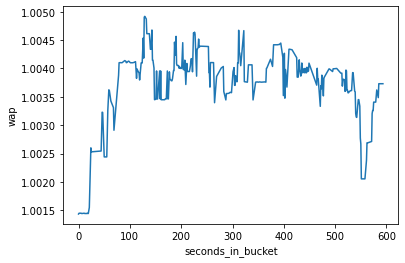

In [13]:
wap_plot = sns.lineplot(x=ex_data["seconds_in_bucket"], y=ex_data["wap"])

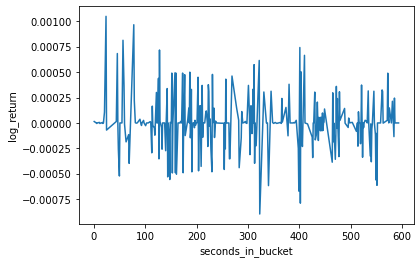

In [14]:
log_return_plot = sns.lineplot(x=ex_data["seconds_in_bucket"], y=ex_data["log_return"])

In [15]:
cal_realized_volatility(ex_data["log_return"]) 

0.004499364172786558

### look at trade_df

In [16]:
trade_df

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0
...,...,...,...,...,...,...
38382736,32767,570,0.999932,100,1,99
38382737,32767,575,0.999932,100,1,99
38382738,32767,579,0.999797,300,3,99
38382739,32767,584,0.999854,172,2,99


## Try to create simple predictor using t-1

In [17]:
naive_predictor = create_baseline_pred(book_df, response_df)
naive_predictor

0         0.004499
1         0.001204
2         0.002369
3         0.002574
4         0.001894
            ...   
428927    0.003691
428928    0.004104
428929    0.003118
428930    0.003661
428931    0.002091
Name: volatility_per_id, Length: 428932, dtype: float64

In [18]:
naive_pred_result = evaluation(response_df["target"], naive_predictor)
naive_pred_result

{'residule': 0        -0.000364
 1         0.000240
 2        -0.000200
 3        -0.000379
 4        -0.000147
             ...   
 428927   -0.000230
 428928   -0.000991
 428929    0.000952
 428930   -0.000304
 428931   -0.000001
 Length: 428932, dtype: float64,
 'true_average': 0.0038804095369522435,
 'prediction_average': 0.004233148050752025,
 'sum_error': -151.3008362011676,
 'average_error': -0.0003527385137997814,
 'mae': 0.0009454384447180171,
 'rmse': 0.0017901718580569119,
 'rmspe': 34.13544901880161,
 'smape': 21.089513908415224,
 'r2': 0.6282703498484288}

#### look like ther naive model mostly will under predict, which tell us that volitality will lead to more volitality

## Try knn regressor using only t-1 data

### Create train validation test set

Note that we don't have to scale the data because log return was already scaled 

In [19]:
t1_predictor = [[i] for i in naive_predictor.tolist()]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(t1_predictor, response_df["target"], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [21]:
from sklearn.neighbors import KNeighborsRegressor

In [22]:
knnr = KNeighborsRegressor(n_neighbors=3)
knnr.fit(np.array(X_train), y_train)

KNeighborsRegressor(n_neighbors=3)

In [23]:
knnr_y_pred = knnr.predict(X_val)

In [24]:
knnr_naive_pred_result = evaluation(y_val, knnr_y_pred)
knnr_naive_pred_result

{'residule': 249043    0.000767
 253218    0.000501
 23977     0.000908
 401871   -0.000208
 393220   -0.000183
             ...   
 228610   -0.000793
 321502    0.000637
 87621     0.000533
 395657   -0.000542
 86228    -0.000352
 Name: target, Length: 85787, dtype: float64,
 'true_average': 0.003886634589483255,
 'prediction_average': 0.003886995669534234,
 'sum_error': -0.030975974333333073,
 'average_error': -3.6108005097880425e-07,
 'mae': 0.0009450498091280343,
 'rmse': 0.0015756106946956706,
 'rmspe': 36.00195768983332,
 'smape': 23.207111206246964,
 'r2': 0.7082730678028843}

### Unsurprisingly Knn can improve the naive predictor
<b> let's push it a bit further

In [25]:
rmse_list = []
k_list = []
for i in range(5, 300, 5):
    knnr = KNeighborsRegressor(n_neighbors=i)
    knnr.fit(np.array(X_train), y_train)
    knnr_y_pred = knnr.predict(X_val)
    knnr_naive_pred_result = evaluation(y_val, knnr_y_pred)
    k_list.append(i)
    rmse_list.append(knnr_naive_pred_result["rmse"])

rmse_array = np.asarray(rmse_list)

<AxesSubplot:>

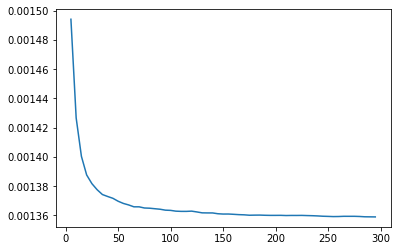

In [26]:
sns.lineplot(x=k_list, y=rmse_list)

<b> to prevent overfit k = 100 will be use

In [50]:
knnr = KNeighborsRegressor(n_neighbors=100)
knnr.fit(np.array(X_train), y_train)
knnr_y_pred = knnr.predict(X_test)
knnr_naive_pred_result = evaluation(y_test, knnr_y_pred)
knnr_naive_pred_result

{'residule': 58607    -0.000119
 356864   -0.000062
 197966    0.000221
 261134   -0.001138
 193238   -0.000234
             ...   
 1792      0.000628
 75578     0.000163
 86262     0.000039
 336477    0.000410
 80054    -0.000488
 Name: target, Length: 85787, dtype: float64,
 'true_average': 0.0038768121863219365,
 'prediction_average': 0.0038759471254940733,
 'sum_error': 0.07421097324000014,
 'average_error': 8.650608278632128e-07,
 'mae': 0.0008038105546590976,
 'rmse': 0.0013911354225504024,
 'rmspe': 30.528598271952568,
 'smape': 19.890906180713632,
 'r2': 0.7778520885129665}

#### using knn regressor to "enhance" the prediction can reduce naive model "underpredictness"

## Linear Regression

See that Knn can improve the model it may because simply reduce the underprediction, OLS can do exactly that

In [51]:
X_train, X_test, y_train, y_test = train_test_split(naive_predictor, response_df["target"], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [59]:
y = y_train
X_train = X_train
X_train = sm.add_constant(X_train)

In [60]:
model = sm.OLS(y,X_train)
ols = model.fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                 8.341e+05
Date:                Sun, 29 Aug 2021   Prob (F-statistic):               0.00
Time:                        16:13:43   Log-Likelihood:             1.3212e+06
No. Observations:              257358   AIC:                        -2.642e+06
Df Residuals:                  257356   BIC:                        -2.642e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0008   4.36e-06    193.009      0.000       0.001       0.001
volatility_per_id     0.7182      0.001    913.303      0.000       0.717       0.720
==============================================================================
Omnibus:                   158052.145   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34780512.780
Skew:                           1.868   Prob(JB):                         0.00
Kurtosis:                      59.829   Cond. No.                         280.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
X_test = sm.add_constant(X_test)
ols_y_pred = ols.predict(X_test)
ols_pred_result = evaluation(y_test, ols_y_pred)
ols_pred_result

{'residule': 58607     0.000012
 356864   -0.000152
 197966    0.000139
 261134   -0.000584
 193238   -0.000355
             ...   
 1792      0.000542
 75578     0.000198
 86262     0.000098
 336477   -0.000038
 80054    -0.000735
 Length: 85787, dtype: float64,
 'true_average': 0.0038768121863219365,
 'prediction_average': 0.0038804175045597774,
 'sum_error': -0.3092894356696877,
 'average_error': -3.6053182378408682e-06,
 'mae': 0.0008382096833765521,
 'rmse': 0.0014465465094071863,
 'rmspe': 35.076485195139874,
 'smape': 21.810533947953186,
 'r2': 0.7598026456981242}

<AxesSubplot:>

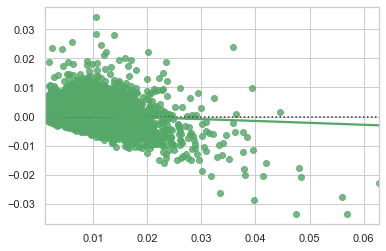

In [70]:
sns.set_theme(style="whitegrid")
sns.residplot(x=ols_y_pred, y=ols_pred_result["residule"], lowess=True, color="g")

## Corr Plot